# Results of the Experiments of UDA for Constraining Star Formation Histories.

This notebook is used to plot the results computed in the `run_experiments` notebook

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# from tslearn.metrics import dtw, dtw_path

## Plotting style

In [5]:
datasets_path = "datasets/"

plt.style.use('seaborn')
matplotlib.rcParams.update({
    "savefig.facecolor": "w",
    "figure.facecolor" : 'w',
    "figure.figsize" : (8,6),
    "text.color": "k",
    "legend.fontsize" : 15,
    "font.size" : 20,
    "axes.edgecolor": "k",
    "axes.labelcolor": "k",
    "axes.linewidth": 3,
    "xtick.color": "k",
    "ytick.color": "k",
    "xtick.labelsize" : 10,
    "ytick.labelsize" : 10,
    "ytick.major.size" : 10,
    "xtick.major.size" : 10,
    "ytick.major.width" : 2,
    "xtick.major.width" : 2,
    "mathtext.fontset" : "cm"
})
dpi = 300

lookback_times = list(pd.read_csv(datasets_path+'simba_z=0.0_sfh.csv', index_col=0))
lookback_times = np.asarray([[float(i.split(',')[0].split('(')[1]),
                              float(i.split(',')[1].split(')')[0])] for i in lookback_times],
                            dtype=np.float32)
lookback_times = [0.5*(val[0]+val[1]) for val in lookback_times]
lookback_times = [round(val, 2) for val in lookback_times]

## Metrics

In [6]:
def tdi(true, pred):
    N_output = len(true)
    path, sim = dtw_path(true, pred)
    Dist = 0
    for ii,jj in path:
            Dist += (ii-jj)*(ii-jj)
    loss_tdi = Dist / (N_output*N_output)
    return loss_tdi

def dtw_all(true, pred):
    if true.ndim <= 1:
        return dtw(true, pred)
    else:
        dtw_sum = 0
        for i in range(len(true)):
            dtw_sum += dtw(true[i], pred[i])
        return dtw_sum / len(true)
    
def tdi_all(true, pred):
    if true.ndim <= 1:
        return tdi(true, pred)
    else:
        tdi_sum = 0
        for i in range(len(true)):
            tdi_sum += tdi(true[i], pred[i])
        return tdi_sum / len(true)
    
def rmse(true, pred):
    return mean_squared_error(true.transpose(), pred.transpose(), squared=False)

def be(true, pred):
    return np.mean(pred-true)

## Load Datasets

In [7]:
datasets_path = "datasets/"

sfh_filename_simbaz0 = datasets_path+'simba_z=0.0_sfh.csv'
sfh_filename_eaglez0 = datasets_path+'eagle_z=0.0_sfh.csv'
sfh_filename_tngz0 = datasets_path+'tng_z=0.0_sfh.csv'

In [9]:
sfh_simbaz0 = pd.read_csv(sfh_filename_simbaz0, index_col=0)
sfh_eaglez0 = pd.read_csv(sfh_filename_eaglez0, index_col=0)
sfh_tngz0 = pd.read_csv(sfh_filename_tngz0, index_col=0)

dict_y_sfh = {"simba": sfh_simbaz0, "eagle": sfh_eaglez0, "tng": sfh_tngz0}

In [12]:
y_true = np.empty((0, dict_y_sfh["simba"].shape[1]))
indexes = {}
sub_indexes = {}
length = 0

for k in ["simba", "tng", "eagle"]:
    y_true = np.concatenate((y_true, dict_y_sfh[k]))
    indexes[k] = np.arange(len(dict_y_sfh[k])) + length
    length += len(dict_y_sfh[k])
    print("Domain %s - n_samples : %i"%(k, len(dict_y_sfh[k])))
    
print("y shape: %s"%str(y_true.shape))

Domain simba - n_samples : 1688
Domain tng - n_samples : 9633
Domain eagle - n_samples : 4697
y shape: (16018, 29)


# Results

In [13]:
TARGET = "eagle"
SOURCES = ["simba", "eagle", "tng"]
SOURCES.remove(TARGET)

print("TARGET = %s\nSOURCES = %s + %s"%(TARGET, SOURCES[0], SOURCES[1]))

TARGET = eagle
SOURCES = simba + tng


## 1. Hyper-parameters

In [14]:
# List of models 
method_list = ["Base", "KLIEP", "KMM", "CORAL", "DeepCORAL", "DANN", "MDD"]

# Number of components of the kernel PCA reduction applied on y
kpca_nb_components = 3

# Bandwidth of the Gaussian kernel of the kernel PCA
kpca_gamma = 3.

# Number of Repetition of the experiment
n_models = 1

## 2. Preprocessing

In [15]:
# Set index for source and target sample
src_index = np.concatenate([indexes[k] for k in SOURCES])
tgt_index = np.concatenate([indexes[k] for k in [TARGET]])

# Scaling y
y = np.copy(y_true)
y_sum = y.sum(1)
y /= y_sum.reshape(-1, 1)

# Reduce y to 3 components of the kernel PCA
kpca = KernelPCA(kpca_nb_components, gamma=kpca_gamma, fit_inverse_transform=True, kernel='rbf')
kpca.fit(y[src_index])
y_pca = kpca.transform(y)

# Converting function
def convert_y(yp_pca, yp_sum):
    yp = kpca.inverse_transform(yp_pca)
    yp *= yp_sum.reshape(-1, 1)
    return yp

# Compute the reconstruction of the true data
y_conv = convert_y(y_pca, y_sum)

## 3. Results

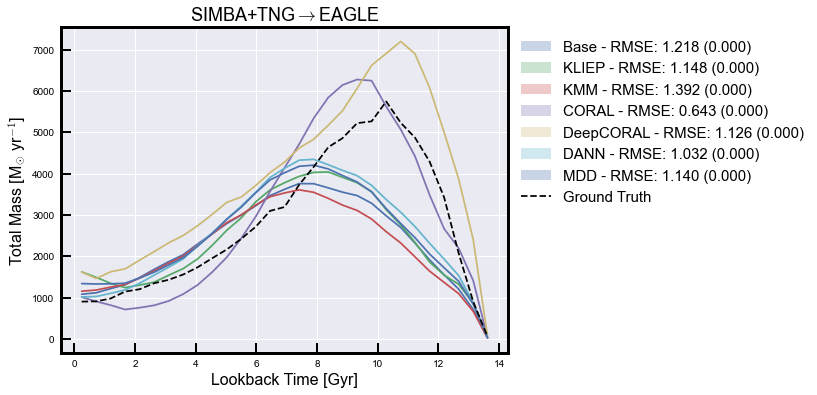

In [21]:
path = "results/%s/"%TARGET

scores = {}
scores_sum = {}

for method in method_list:

    scores[method] = {"rmse": [], "mae": [], "be": [], "dtw": [], "tdi": []}
    scores_sum[method] = {"rmse": [], "mae": [], "be": [], "dtw": [], "tdi": []}
    all_conv = []

    for i in range(n_models):

        try:
            filepath_conv = path+"%s_conv_%i.npy"%(method, i)
            yp_conv = np.load(filepath_conv)
            all_conv.append(yp_conv)
            
            for metric, name in zip([rmse, mean_absolute_error, be], #, dtw_all, tdi_all
                                    scores[method].keys()):
                scores[method][name].append(metric(y_true[tgt_index], yp_conv[tgt_index]))
                scores_sum[method][name].append(metric(y_true[tgt_index].sum(0), yp_conv[tgt_index].sum(0)))

        except:
            print(method, i)

    all_conv = np.stack(all_conv, -1)
    
    yp_conv_sum = all_conv[tgt_index].sum(0)
    
    mean = yp_conv_sum.mean(-1)
    std = yp_conv_sum.std(-1)
    
    rmse_mu = np.mean(np.sqrt(np.mean(np.square(y_true[tgt_index].sum(0)
                                                - yp_conv_sum.transpose()), 1))/1000.)
    rmse_std = np.std(np.sqrt(np.mean(np.square(y_true[tgt_index].sum(0)
                                                - yp_conv_sum.transpose()), 1))/1000.)
    
    plt.plot(lookback_times, mean)
    plt.fill_between(lookback_times,
                     mean-2*std,
                     mean+2*std,
                     alpha=0.3,
                     label=method + " - RMSE: %.3f (%.3f)"%(rmse_mu, rmse_std)
                    )

    plt.tick_params(direction ='in')
    
plt.xlabel("Lookback Time [Gyr]", fontsize=16)
plt.ylabel(r'Total Mass [M$_{\odot}$ yr$^{-1}$] ', fontsize=16)
plt.title(("%s+%s"%(SOURCES[0], SOURCES[1])).upper() + r"$\rightarrow$"+ ("%s"%TARGET).upper(),
          fontsize=18)
    
plt.plot(lookback_times, y_true[tgt_index].sum(0), label="Ground Truth", c="k", ls="--")  
plt.legend(bbox_to_anchor=(1, 1.))
plt.show()